## Plot the Normative model for one Voxel

In [18]:
import os
import pickle
import pandas as pd
import numpy as np
import pcntoolkit as ptk 
from pcntoolkit.dataio.fileio import load as ptkload
from pcntoolkit.dataio.fileio import save as ptksave
from pcntoolkit.normative import predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix, calibration_descriptives
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [19]:
root_dir = '/project_cephfs/3022017.06/projects/wholebrain_blr/lifespan/'
data_dir = os.path.join(root_dir,'data/')
mask_nii = os.path.join(data_dir,'gm_mask.nii.gz')
proc_dir = os.path.join(root_dir,'aff+nonlin_jac_char')
extension = '_01'
w_dir = os.path.join(proc_dir,'vox_powell'+extension+'/')

In [20]:
# filenames for the covariates
cov_file_tr = os.path.join(proc_dir, 'cov_bspline_tr'+extension+'.txt')
cov_file_te = os.path.join(proc_dir, 'cov_bspline_te'+extension+'.txt')

# filenames for the responses
resp_file_tr = os.path.join(proc_dir,'resp_tr'+extension+'.pkl')
resp_file_te = os.path.join(proc_dir,'resp_te'+extension+'.pkl')

# normative modelling parameters
alg = 'blr'
warp ='WarpSinArcsinh'
warp_reparam = 'True'
optimizer = 'l-bfgs-b'

# limits for basis expansion (ages of participants +/- 5)
xmin = 5 
xmax = 90

In [21]:
df_tr = pd.read_csv(os.path.join(proc_dir,'dem_tr'+extension+'.csv'))
df_te = pd.read_csv(os.path.join(proc_dir,'dem_te'+extension+'.csv'))

# design matrix parameters
cols_cov = ['age','sex']
site_ids =  sorted(set(df_tr['site'].to_list()))

#%%
sex = 1
alpha=0.4

if sex == 1:
    clr = '#666666'
    clr1 = '#39c0ba'
    gender = 'male'
else:
    clr = '#666666'
    clr1 = '#f35b6a'
    gender = 'female'


In [22]:
# create dummy data for visualisation
xx = np.arange(xmin,xmax,0.5)
if len(cols_cov) == 1:
    print('fitting sex specific model')
    X0_dummy = np.zeros((len(xx), 1))
    X0_dummy[:,0] = xx
    df_tr = df_tr.loc[df_tr['sex'] == sex]
    df_te = df_te.loc[df_te['sex'] == sex]
else:
    X0_dummy = np.zeros((len(xx), 2))
    X0_dummy[:,0] = xx
    X0_dummy[:,1] = sex
    
print('configuring dummy data for each all',len(site_ids), 'sites')  
for sid, site in enumerate(site_ids):
    site_dummy = [site] * len(xx)
    X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=site_dummy, all_sites = site_ids)
    ptksave(X_dummy, os.path.join(proc_dir,'cov_bspline_dummy_' + site + '.txt'))

print('configuring dummy data for mean')
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites = site_ids)
ptksave(X_dummy, os.path.join(proc_dir,'cov_bspline_dummy_mean.txt'))

#%%
# load the index in volumetric form
idxvol = ptkload('/project_cephfs/3022017.06/projects/wholebrain_blr/lifespan/aff+nonlin_jac_char/idx.nii.gz', mask=mask_nii, vol=True)

# find the voxel coordinates for a given value. Here we take a voxel at random
#vox_coord = (45,69,44,0)
vox_id = int(idxvol[vox_coord])
vox_id = 2000
model_num = vox_id

configuring dummy data for each all 7 sites
configuring dummy data for mean


In [23]:
print('vox_id :', vox_id, '->','vox_coord :', vox_coord)
print('Running voxel:', vox_id)
model_path = os.path.join(w_dir, 'Models', 'NM_0_' + str(vox_id) + '_estimate.pkl')

# set output dir 
os.chdir(w_dir)

# load the responses
y_tr = ptkload(resp_file_tr)
y_te = ptkload(resp_file_te)

# restrict to only one phenotype
y_tr = y_tr[:,model_num]
y_te = y_te[:,model_num]   
y_tr = y_tr[:, np.newaxis]  
y_te = y_te[:, np.newaxis]

# load the covariates
X_tr = ptkload(cov_file_tr)
X_te = ptkload(cov_file_te)

# Make prdictions with test data
yhat_te, s2_te, Z = predict(cov_file_te, 
                            alg = alg, 
                            respfile = resp_file_te, 
                            model_path = os.path.join(w_dir,'Models'), 
                            outputsuffix = '_predict',
                            models = [vox_id])

vox_id : 2000 -> vox_coord : (48, 54, 43, 0)
Running voxel: 2000
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


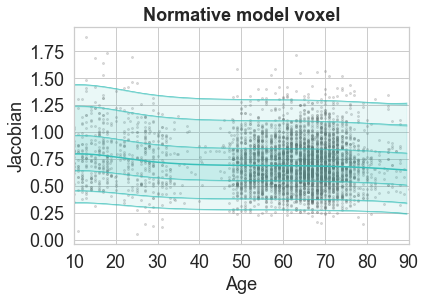

In [24]:
# set up the dummy covariates for the dummy data
print('Making predictions with dummy covariates (for visualisation)')
cov_file_dummy = os.path.join(proc_dir, 'cov_bspline_dummy')
cov_file_dummy = cov_file_dummy + '_mean.txt'

# make dummy predictions
yhat, s2 = predict(cov_file_dummy, 
                   alg='blr', 
                   respfile=None, 
                   model_path=os.path.join(w_dir,'Models'), 
                   outputsuffix='_dummy',
                   models = [model_num])
    
with open(os.path.join(w_dir,'Models', 'NM_0_'+str(model_num)+'_estimate.pkl'), 'rb') as handle:
    nm = pickle.load(handle) 
    
    
# compute error metrics
if warp is None:
    # compute evaluation metrics
    metrics = evaluate(y_te, yhat_te)  
        
    # compute MSLL manually as a sanity check
    y_tr_mean = np.array( [[np.mean(y_tr)]] )
    y_tr_var = np.array( [[np.var(y_tr)]] )
    MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
     
else:
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W = nm.blr.warp
        
    # warp and plot dummy predictions
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
        
    # warp predictions
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
       
    # evaluation metrics
    metrics = evaluate(y_te, med_te)
        
    # compute MSLL manually
    y_te_w = W.f(y_te, warp_param)
    y_tr_w = W.f(y_tr, warp_param)
    y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
    y_tr_var = np.array( [[np.var(y_tr_w)]] )
    MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
# plot the data points
y_te_rescaled_all = np.zeros_like(y_te)
for sid, site in enumerate(site_ids):
                
    # plot the true test data points
    if len(cols_cov) == 1:
        # sex-specific model
        idx = np.where(X_te[:,sid+len(cols_cov)+1] !=0)
    else:
        idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))
    if len(idx[0]) == 0:
        print('No data for site', sid, site, 'skipping...')
        continue
    else:
        idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
        
    # adjust the intercept
    if warp is None:
        y_te_rescaled = y_te[idx]#- np.median(y_te[idx])+ np.median(yhat[idx_dummy])
    else:            
        y_te_rescaled = y_te[idx]# - np.median(y_te[idx]) + np.median(med[idx_dummy])
    plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 0.2)   
        
    y_te_rescaled_all[idx] = y_te_rescaled

# plot the centiles
if warp is None:
    plt.plot(xx, yhat, color = clr)
    plt.fill_between(xx, np.squeeze(yhat-0.67*np.sqrt(s2)), 
                     np.squeeze(yhat+0.67*np.sqrt(s2)), 
                     color=clr, alpha = 0.1)
    plt.fill_between(xx, np.squeeze(yhat-1.64*np.sqrt(s2)), 
                     np.squeeze(yhat+1.64*np.sqrt(s2)), 
                     color=clr, alpha = 0.1)
    plt.fill_between(xx, np.squeeze(yhat-2.33*np.sqrt(s2)), 
                     np.squeeze(yhat+2.32*np.sqrt(s2)), 
                     color=clr, alpha = 0.1)
    plt.plot(xx, np.squeeze(yhat-0.67*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat+0.67*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat-1.64*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat+1.64*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat-2.33*np.sqrt(s2)),color=clr, linewidth=0.5)
    plt.plot(xx, np.squeeze(yhat+2.32*np.sqrt(s2)),color=clr, linewidth=0.5)
else:
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W = nm.blr.warp
        
    # warp and plot dummy predictions
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
        
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta
    s2s = s2-s2n
        
    # plot the centiles
    plt.plot(xx, med, clr1)
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95]) 
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
            
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr1)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr1)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr1)
            
    # make the width of each line proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr1)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr1)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr1)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr1)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr1)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr1)

    plt.plot(xx, pr_int25[:,0],color=clr1, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr1, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr1, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr1, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr1, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr1, linewidth=0.5)
            
plt.xlabel('Age', fontsize=18)
plt.ylabel('Jacobian', fontsize=18) 
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlim((10,90))
plt.title('Normative model voxel', fontweight="bold", fontsize=18)
plt.show()

In [25]:
BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
print('NLL =', nm.neg_log_lik)
print('BIC =', BIC)
print('EV = ', metrics['EXPV'])
print('MSLL = ', MSLL) 
[skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)

NLL = -1072.0815967855392
BIC = -2107.4734703754666
EV =  [0.01751486]
MSLL =  [-0.00936427]


<AxesSubplot: title={'center': 'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

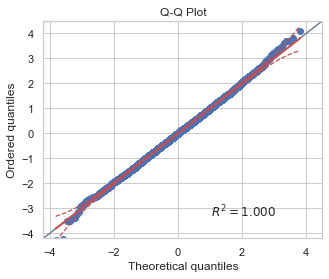

In [26]:
pg.qqplot(Z, dist='norm', confidence=0.95)